In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from functools import reduce
from sklearn.linear_model import LinearRegression

''' Leitura dos data-sets. '''
ituporanga_nivel_df = pd.read_table('83250000ITUPORANGA_2962005-1032014-nível.txt')
taio_nivel_df = pd.read_table('83050000TAIÓ_2962005-1442014-nível.txt')
rio_do_sul_nivel_df = pd.read_table('83300200RIODOSUL-NOVO_2982005-1422014 -nível.txt')

ituporanga_chuva_df = pd.read_table('83250000ITUPORANGA_3172005-1442014-chuva.txt')
taio_chuva_df = pd.read_table('83050000TAIÓ_2962005-1442014-chuva.txt')

In [7]:
''' Transforma e une os data-sets em um data-frame legível. '''
default_nivel_column_name = '.........Data e Hora..........Nível (cm)'
default_chuva_column_name = '.........Data e Hora..........Chuva (mm)'
whitespace_regex = ' +'

ituporanga_nivel_division = ituporanga_nivel_df[default_nivel_column_name].str.split(whitespace_regex)
taio_nivel_division = taio_nivel_df[default_nivel_column_name].str.split(whitespace_regex)
rio_do_sul_nivel_division = rio_do_sul_nivel_df[default_nivel_column_name].str.split(whitespace_regex)

ituporanga_nivel_df['data'] = ituporanga_nivel_division.str.get(1)
taio_nivel_df['data'] = taio_nivel_division.str.get(1)
rio_do_sul_nivel_df['data'] = rio_do_sul_nivel_division.str.get(1)

ituporanga_nivel_df['hora'] = ituporanga_nivel_division.str.get(2)
taio_nivel_df['hora'] = taio_nivel_division.str.get(2)
rio_do_sul_nivel_df['hora'] = rio_do_sul_nivel_division.str.get(2)

ituporanga_nivel_df['data/hora'] = ituporanga_nivel_df['data'] + ' ' + ituporanga_nivel_df['hora']
taio_nivel_df['data/hora'] = taio_nivel_df['data'] + ' ' + taio_nivel_df['hora']
rio_do_sul_nivel_df['data/hora'] = rio_do_sul_nivel_df['data'] + ' ' + rio_do_sul_nivel_df['hora']

ituporanga_nivel_df['nivel/ituporanga'] = pd.to_numeric(ituporanga_nivel_division.str.get(3), errors='coerce')
taio_nivel_df['nivel/taio'] = pd.to_numeric(taio_nivel_division.str.get(3), errors='coerce')
rio_do_sul_nivel_df['nivel/rio do sul'] = pd.to_numeric(rio_do_sul_nivel_division.str.get(3), errors='coerce')

ituporanga_nivel_df.drop(default_nivel_column_name, inplace=True, axis=1)
taio_nivel_df.drop(default_nivel_column_name, inplace=True, axis=1)
rio_do_sul_nivel_df.drop(default_nivel_column_name, inplace=True, axis=1)

ituporanga_chuva_division = ituporanga_chuva_df[default_chuva_column_name].str.split(whitespace_regex)
taio_chuva_division = taio_chuva_df[default_chuva_column_name].str.split(whitespace_regex)

ituporanga_chuva_df['data'] = ituporanga_chuva_division.str.get(1)
taio_chuva_df['data'] = taio_chuva_division.str.get(1)

ituporanga_chuva_df['hora'] = ituporanga_chuva_division.str.get(2)
taio_chuva_df['hora'] = taio_chuva_division.str.get(2)

ituporanga_chuva_df['data/hora'] = ituporanga_chuva_df['data'] + ' ' + ituporanga_chuva_df['hora']
taio_chuva_df['data/hora'] = taio_chuva_df['data'] + ' ' + taio_chuva_df['hora']

ituporanga_chuva_df['chuva/ituporanga'] = pd.to_numeric(ituporanga_chuva_division.str.get(3), errors='coerce')
taio_chuva_df['chuva/taio'] = pd.to_numeric(taio_chuva_division.str.get(3), errors='coerce')

ituporanga_chuva_df.drop(default_chuva_column_name, inplace=True, axis=1)
taio_chuva_df.drop(default_chuva_column_name, inplace=True, axis=1)

dfs = [taio_nivel_df, taio_chuva_df, rio_do_sul_nivel_df, ituporanga_nivel_df, ituporanga_chuva_df]

df_merge_cb = lambda merged_dfs, next_df: pd.merge(merged_dfs, next_df, how='left')
df_merged = reduce(df_merge_cb, dfs).dropna()

df_merged.head()

,data,hora,data/hora,nivel/taio,chuva/taio,nivel/rio do sul,nivel/ituporanga,chuva/ituporanga
678,31/07/2005,21:00:00,31/07/2005 21:00:00,98.0,0.0,171.0,30.0,3.0
679,31/07/2005,22:00:00,31/07/2005 22:00:00,98.0,0.0,171.0,39.0,12.0
680,31/07/2005,23:00:00,31/07/2005 23:00:00,97.0,0.0,171.0,59.0,19.0
681,01/08/2005,00:00:00,01/08/2005 00:00:00,97.0,0.0,170.0,82.0,5.0
684,01/08/2005,03:00:00,01/08/2005 03:00:00,97.0,0.0,170.0,27.0,1.0


In [8]:
''' 
Separação dos dados de treinamento/teste.
Optei por remover das colunas com os níveis em mm de chuva, pois elas tiveram pouca influência nos resultados pelo que testei, isso também foi constatado na matriz de correlação entre as colunas mais adiante.
Optei também por separar 80% dos dados para treinamento e 20% para teste.
'''
x_columns = df_merged[['nivel/taio', 'nivel/ituporanga']]
y_column = df_merged['nivel/rio do sul']

train_size = int(0.8 * len(y_column))
test_size = int(0.2 * len(y_column))

x_train = x_columns[0:train_size]
y_train = y_column[0:train_size]

x_test = x_columns[train_size:train_size + test_size]
y_test = y_column[train_size:train_size + test_size]

Coeficiente R^2 obtido pelo LinearRegression com os dados de teste: 0.9625867347120723 

                  Coeficientes das respectivas colunas
nivel/taio                                    0.519733
nivel/ituporanga                              1.125121 



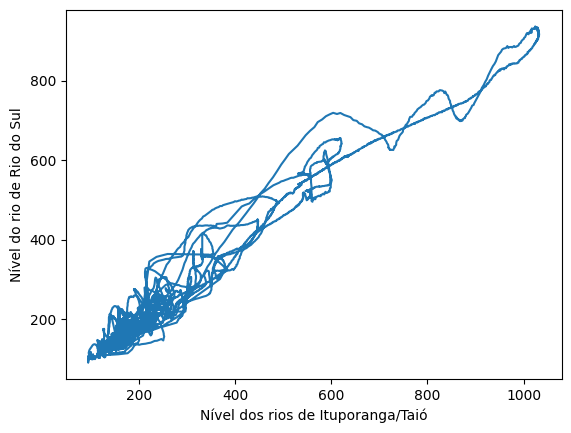

In [21]:
''' Testes de predição das cheias em Rio do Sul com o modelo LinearRegression. '''
lr_model = LinearRegression()
lr_model.fit(X=x_train, y=y_train)
lr_model_r2 = lr_model.score(X=x_test, y=y_test)
lr_model_prediction = lr_model.predict(X=x_test)

coefficients = pd.DataFrame(lr_model.coef_, x_columns.columns, columns=['Coeficientes das respectivas colunas'])

print(f'Coeficiente R^2 obtido pelo LinearRegression com os dados de teste: {lr_model_r2} \n')
print(f'{coefficients} \n')

plt.plot(y_test, lr_model_prediction)
plt.xlabel('Nível dos rios de Ituporanga/Taió')
plt.ylabel('Nível do rio de Rio do Sul')
plt.show();

In [10]:
''' 
Exibe a matriz de correlação entre as colunas. 
Existe uma alta correlação entre as colunas de nível das cidades, principalmente entre Rio do Sul e Taió.
'''
corr = df_merged.corr()
corr.style.background_gradient(cmap='coolwarm')

,nivel/taio,chuva/taio,nivel/rio do sul,nivel/ituporanga,chuva/ituporanga
nivel/taio,1.000000,0.005800,0.945354,0.811105,0.018446
chuva/taio,0.005800,1.000000,-0.000536,0.012642,0.140605
nivel/rio do sul,0.945354,-0.000536,1.000000,0.893384,0.021666
nivel/ituporanga,0.811105,0.012642,0.893384,1.000000,0.035569
chuva/ituporanga,0.018446,0.140605,0.021666,0.035569,1.000000
